In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
import os
plt.style.use('classic')

# Предобработка и исследование данных

In [2]:
results = pd.read_csv(r'datasets\results.csv')
races = pd.read_csv(r'datasets\races.csv')
quali = pd.read_csv(r'datasets\qualifying.csv')
drivers = pd.read_csv(r'datasets\drivers.csv')
constructors = pd.read_csv(r'datasets\constructors.csv')
circuit = pd.read_csv(r'datasets\circuits.csv')

In [3]:
circuit = circuit.drop(['url'], axis=1)

In [4]:
#совмещение всех данных в один датафрейм
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'])

In [5]:
#удаление ненужных колонок датафрейма
data = df5.drop(['round','circuitId','time_x','url_x','resultId','driverId',
                 'constructorId','number_x','positionText','position_x',
                 'positionOrder','laps','time_y','rank',
                 'fastestLapTime','fastestLapSpeed','qualifyId','driverRef','number','code','url_y','circuitRef',
                 'location','lat','lng','alt','number_y','points','constructorRef','name_x','raceId','fastestLap','q2','q3','milliseconds','q1'],axis=1)

In [6]:
data.head()

,year,date,grid,statusId,position_y,forename,surname,dob,nationality_x,name_y,nationality_y,url,name,country
0,2009,2009-03-29,1,1,1,Jenson,Button,1980-01-19,British,Brawn,British,http://en.wikipedia.org/wiki/Brawn_GP,Albert Park Grand Prix Circuit,Australia
1,2009,2009-03-29,2,1,2,Rubens,Barrichello,1972-05-23,Brazilian,Brawn,British,http://en.wikipedia.org/wiki/Brawn_GP,Albert Park Grand Prix Circuit,Australia
2,2009,2009-03-29,20,1,8,Jarno,Trulli,1974-07-13,Italian,Toyota,Japanese,http://en.wikipedia.org/wiki/Toyota_Racing,Albert Park Grand Prix Circuit,Australia
3,2009,2009-03-29,19,1,6,Timo,Glock,1982-03-18,German,Toyota,Japanese,http://en.wikipedia.org/wiki/Toyota_Racing,Albert Park Grand Prix Circuit,Australia
4,2009,2009-03-29,10,1,12,Fernando,Alonso,1981-07-29,Spanish,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...,Albert Park Grand Prix Circuit,Australia


In [7]:
#учитываем данные только с 1980 года
data = data[data['year']>=1980]

In [8]:
#данные 2018 года
data_new = data[data['year'] == 2018]

In [9]:
data_new.head()

,year,date,grid,statusId,position_y,forename,surname,dob,nationality_x,name_y,nationality_y,url,name,country
7506,2018,2018-03-25,3,1,3,Sebastian,Vettel,1987-07-03,German,Ferrari,Italian,http://en.wikipedia.org/wiki/Scuderia_Ferrari,Albert Park Grand Prix Circuit,Australia
7507,2018,2018-03-25,1,1,1,Lewis,Hamilton,1985-01-07,British,Mercedes,German,http://en.wikipedia.org/wiki/Mercedes-Benz_in_...,Albert Park Grand Prix Circuit,Australia
7508,2018,2018-03-25,2,1,2,Kimi,Räikkönen,1979-10-17,Finnish,Ferrari,Italian,http://en.wikipedia.org/wiki/Scuderia_Ferrari,Albert Park Grand Prix Circuit,Australia
7509,2018,2018-03-25,8,1,5,Daniel,Ricciardo,1989-07-01,Australian,Red Bull,Austrian,http://en.wikipedia.org/wiki/Red_Bull_Racing,Albert Park Grand Prix Circuit,Australia
7510,2018,2018-03-25,10,1,11,Fernando,Alonso,1981-07-29,Spanish,McLaren,British,http://en.wikipedia.org/wiki/McLaren,Albert Park Grand Prix Circuit,Australia


In [10]:
#переименование некоторых колонок и преобразование дат в тип данных datetime
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [11]:
data.head()

,year,date,quali_pos,statusId,position,forename,surname,dob,driver_nationality,constructor,constructor_nationality,url,GP_name,country,driver
0,2009,2009-03-29,1,1,1,Jenson,Button,1980-01-19,British,Brawn,British,http://en.wikipedia.org/wiki/Brawn_GP,Albert Park Grand Prix Circuit,Australia,Jenson Button
1,2009,2009-03-29,2,1,2,Rubens,Barrichello,1972-05-23,Brazilian,Brawn,British,http://en.wikipedia.org/wiki/Brawn_GP,Albert Park Grand Prix Circuit,Australia,Rubens Barrichello
2,2009,2009-03-29,20,1,8,Jarno,Trulli,1974-07-13,Italian,Toyota,Japanese,http://en.wikipedia.org/wiki/Toyota_Racing,Albert Park Grand Prix Circuit,Australia,Jarno Trulli
3,2009,2009-03-29,19,1,6,Timo,Glock,1982-03-18,German,Toyota,Japanese,http://en.wikipedia.org/wiki/Toyota_Racing,Albert Park Grand Prix Circuit,Australia,Timo Glock
4,2009,2009-03-29,10,1,12,Fernando,Alonso,1981-07-29,Spanish,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formul...,Albert Park Grand Prix Circuit,Australia,Fernando Alonso


In [12]:
#создаем параметр возраста для водителя по формуле: (день_рождения - дата_проведения_заезда) 
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [13]:
#Многие команды(конструкторы) меняли свои наименования на протяжении времени(продажа, ребрендинг), поэтому заменяем старые названия на новые с целью сохранения целостности данных
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Racing Point' if x=='Aston Martin' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Renault' if x=='Alpine' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [14]:
#делаем остальные столбцы более информативными(объединяем те, что можно объединить, преобразуем и тд)
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [15]:
data

,year,date,quali_pos,statusId,position,forename,surname,dob,driver_nationality,constructor,constructor_nationality,url,GP_name,country,driver,age_at_gp_in_days,driver_home,constructor_home
0,2009,2009-03-29,1,1,1,Jenson,Button,1980-01-19,Bri,Brawn,Bri,http://en.wikipedia.org/wiki/Brawn_GP,Albert Park Grand Prix Circuit,Aus,Jenson Button,10662,0,0
1,2009,2009-03-29,2,1,2,Rubens,Barrichello,1972-05-23,Bra,Brawn,Bri,http://en.wikipedia.org/wiki/Brawn_GP,Albert Park Grand Prix Circuit,Aus,Rubens Barrichello,13459,0,0
2,2009,2009-03-29,20,1,8,Jarno,Trulli,1974-07-13,Ita,Toyota,Jap,http://en.wikipedia.org/wiki/Toyota_Racing,Albert Park Grand Prix Circuit,Aus,Jarno Trulli,12678,0,0
3,2009,2009-03-29,19,1,6,Timo,Glock,1982-03-18,Ger,Toyota,Jap,http://en.wikipedia.org/wiki/Toyota_Racing,Albert Park Grand Prix Circuit,Aus,Timo Glock,9873,0,0
4,2009,2009-03-29,10,1,12,Fernando,Alonso,1981-07-29,Spa,Renault,Fre,http://en.wikipedia.org/wiki/Renault_in_Formul...,Albert Park Grand Prix Circuit,Aus,Fernando Alonso,10105,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8398,2020,2020-07-19,18,11,18,Romain,Grosjean,1986-04-17,Fre,Haas F1 Team,Ame,http://en.wikipedia.org/wiki/Haas_F1_Team,Hungaroring,Hun,Romain Grosjean,12512,0,0
8399,2020,2020-07-19,19,11,19,Antonio,Giovinazzi,1993-12-14,Ita,Alfa Romeo,Ita,http://en.wikipedia.org/wiki/Alfa_Romeo_in_For...,Hungaroring,Hun,Antonio Giovinazzi,9714,0,0
8400,2020,2020-07-19,12,11,12,George,Russell,1998-02-15,Bri,Williams,Bri,http://en.wikipedia.org/wiki/Williams_Grand_Pr...,Hungaroring,Hun,George Russell,8190,0,0
8401,2020,2020-07-19,15,15,15,Nicholas,Latifi,1995-06-29,Can,Williams,Bri,http://en.wikipedia.org/wiki/Williams_Grand_Pr...,Hungaroring,Hun,Nicholas Latifi,9152,0,0


In [16]:
#указывание статуса гонки для пилота и конструктора (1 - не завершил гонку, 0 - завершил)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],axis = 1,inplace=True)

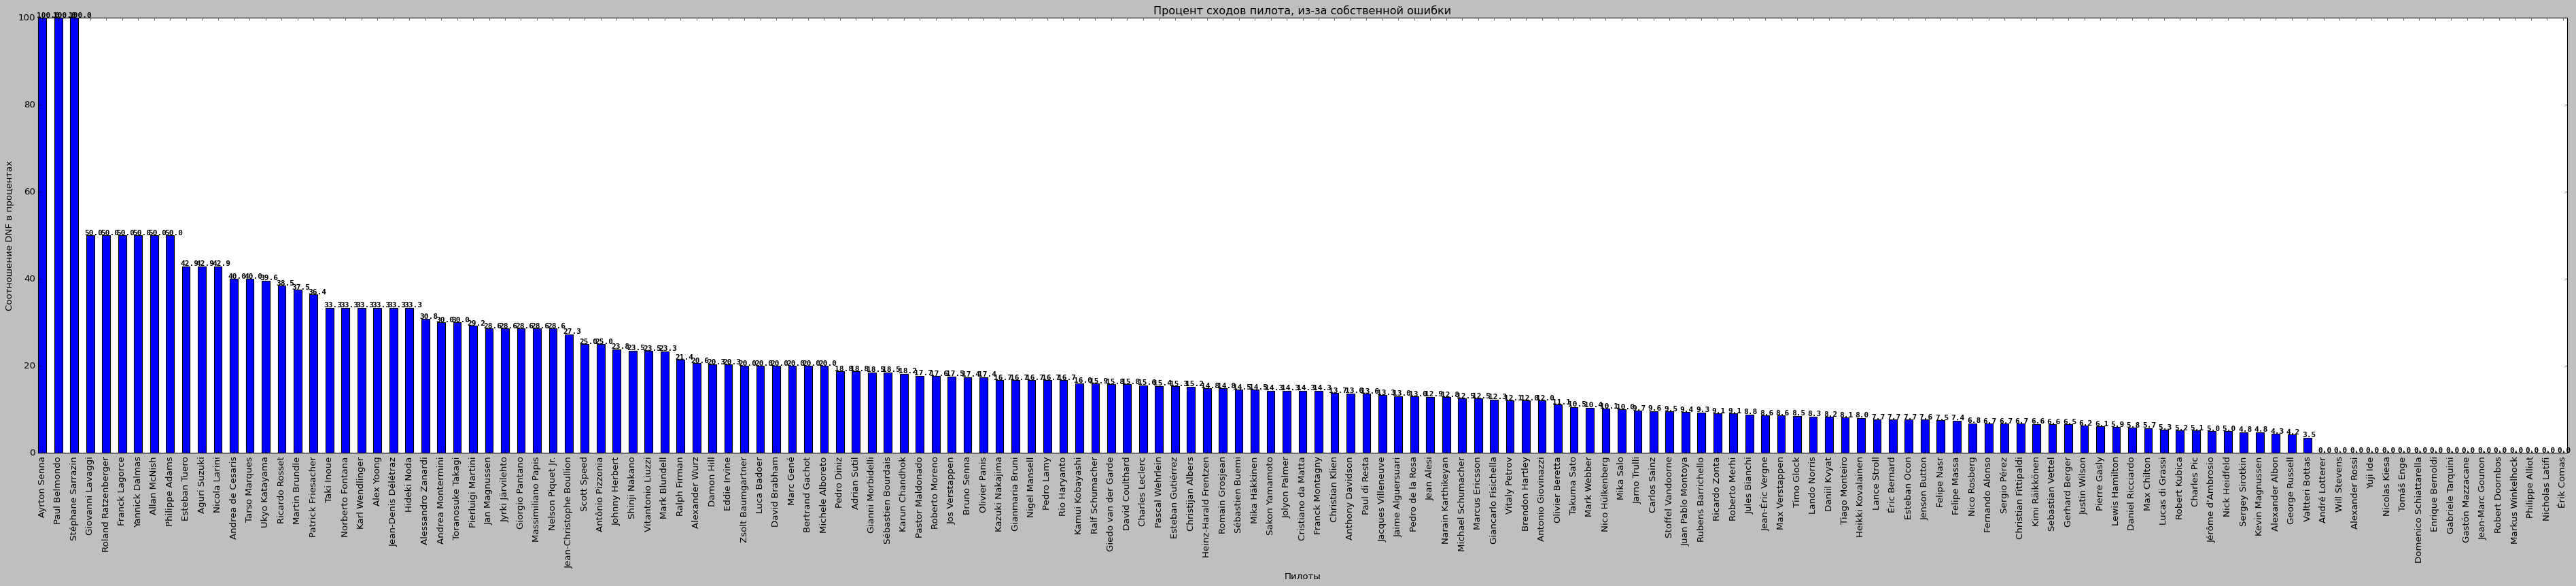

In [17]:
font = {
    'family':'monospace',
    'color':'black',
    'weight':'bold',
    'size':10
}

#строим график соотношения сходов из-за ошибки пилота ко всем его сходам в процентном соотношении
dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver*100/driver_race_entered).sort_values(ascending=False)
plt.figure(figsize=(60,10))

bars = plt.bar(x=driver_dnf_ratio.index,height=driver_dnf_ratio,align='center',width=0.5)

plt.xticks(rotation=90)
plt.xlabel('Пилоты')
plt.ylabel('Соотношение DNF в процентах')
plt.title('Процент сходов пилота, из-за собственной ошибки')

for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.1,yval+0.15,f'{round(yval,1)}',fontdict=font)
    
plt.show()

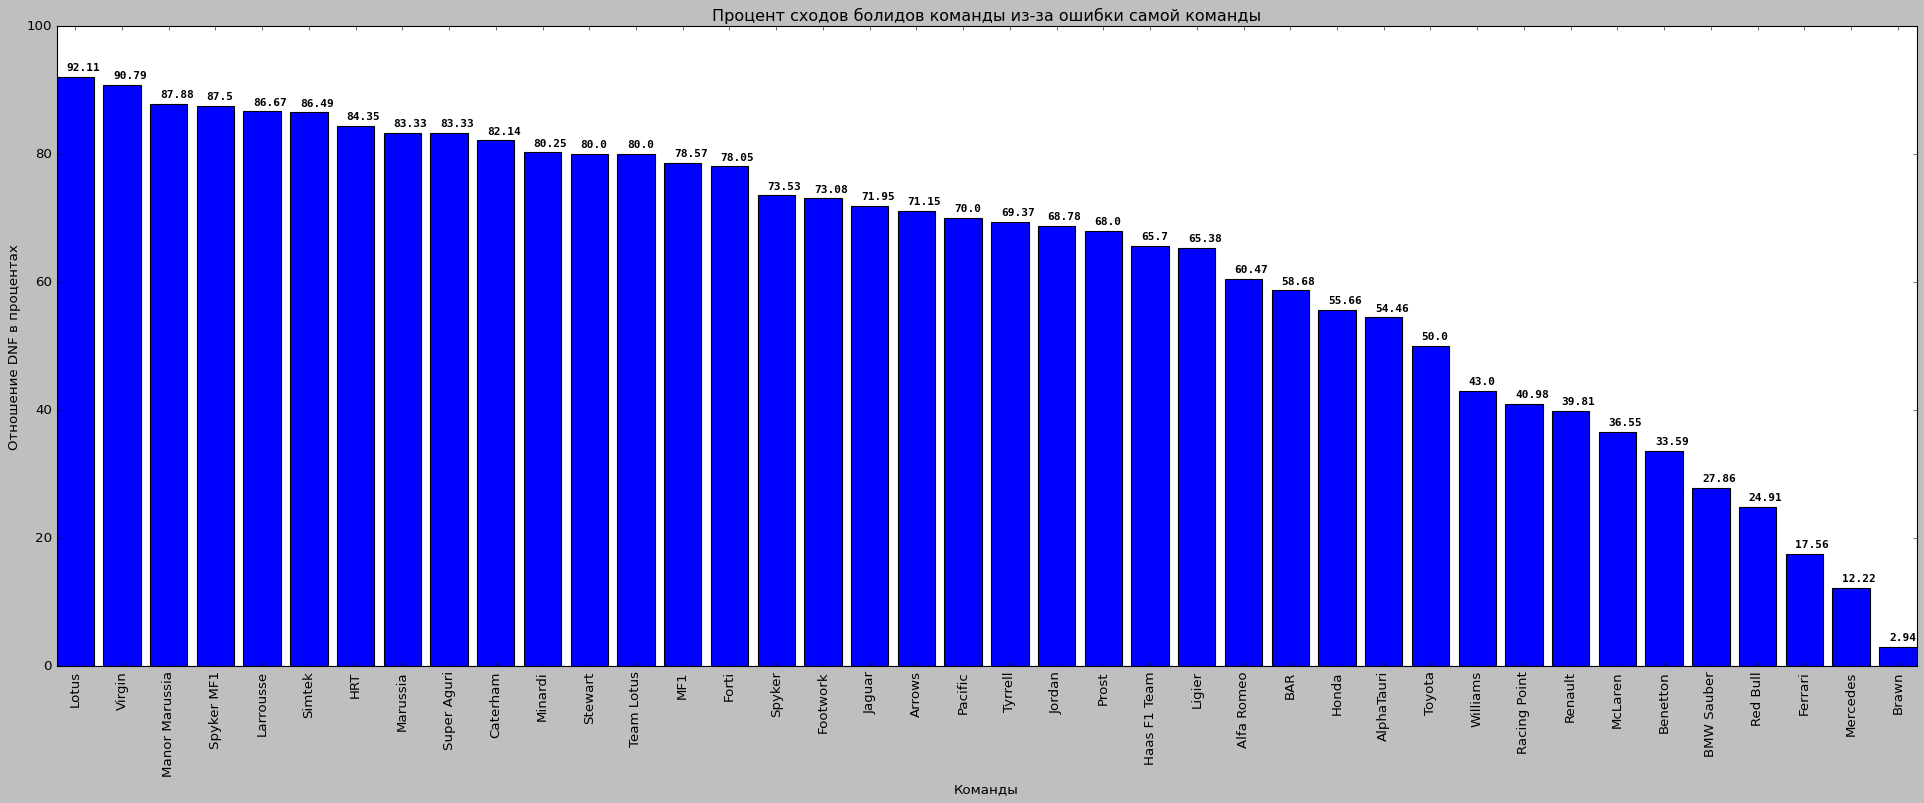

In [18]:
#такой же график, но для команд(конструкторов)
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor*100/constructor_race_entered).sort_values(ascending=False)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_dnf_ratio.index,height=constructor_dnf_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Команды')
plt.ylabel('Отношение DNF в процентах')
plt.title('Процент сходов болидов команды из-за ошибки самой команды')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.21,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

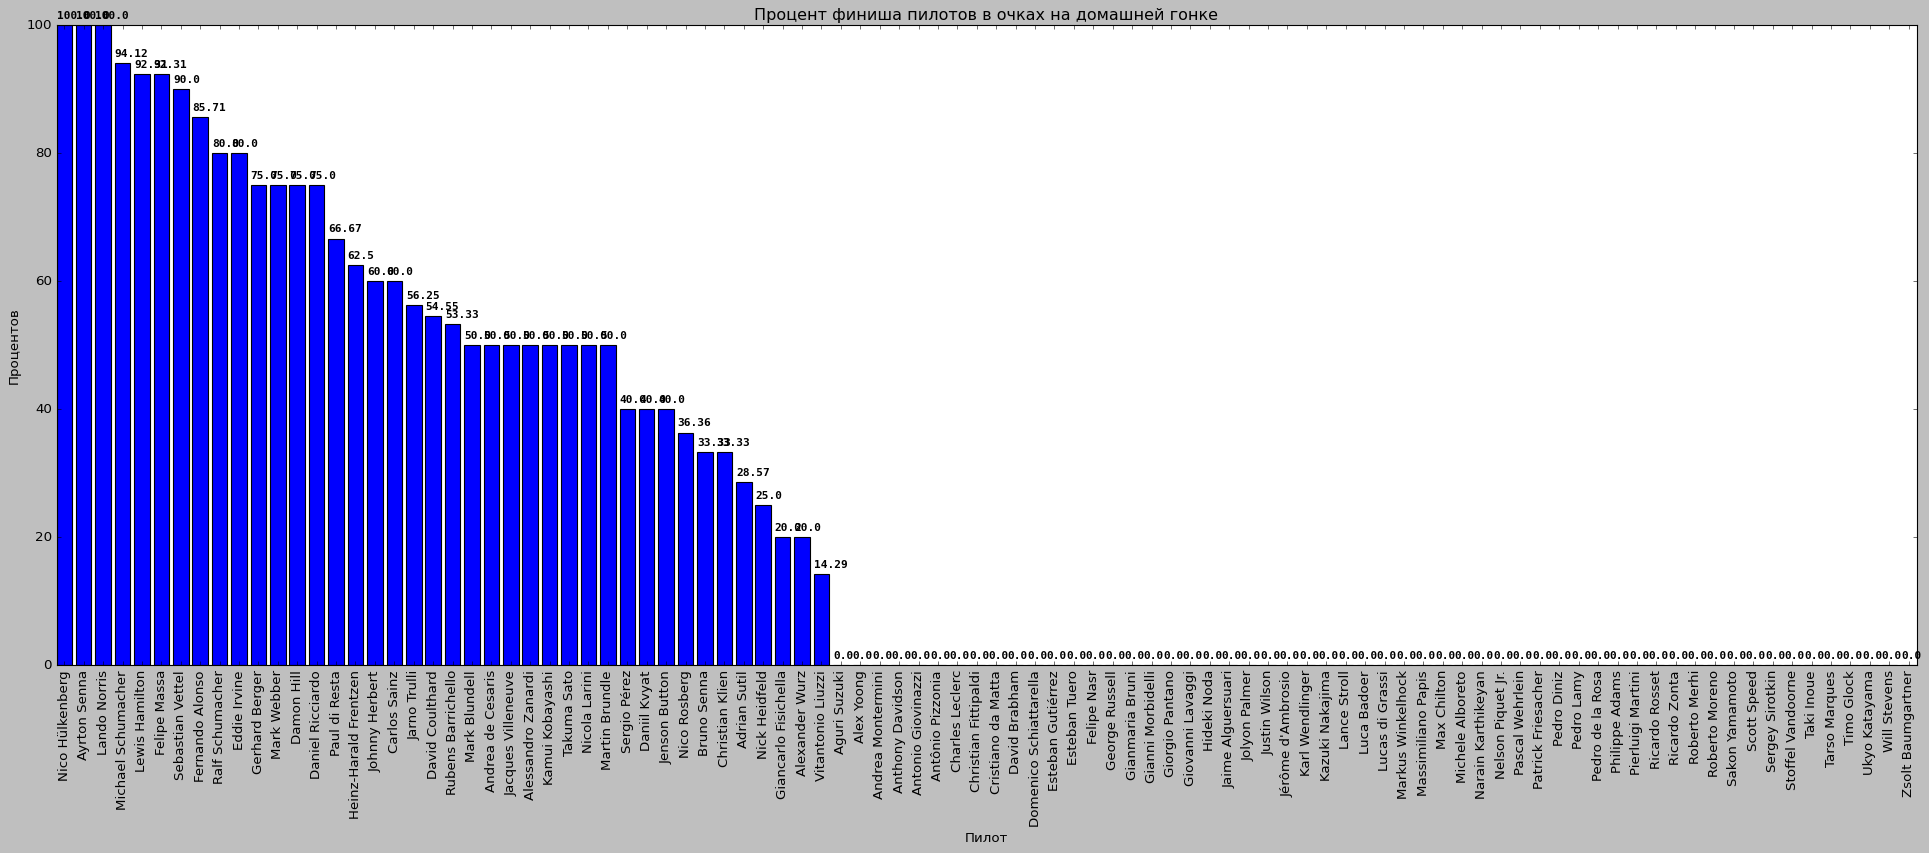

In [22]:
#график, отображающий процентное соотношение финишей в очковой зоне для каждого пилота на его родной гонке(гонка проходящая в стране, откуда он родом).
driver_home_points_finish = data.loc[(data['position']<11)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver')['driver_home'].sum()
driver_home_point_finish_ratio = (driver_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_point_finish_ratio.index,height=driver_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Пилот')
plt.ylabel('Процентов')
plt.title('Процент финиша пилотов в очках на домашней гонке')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)

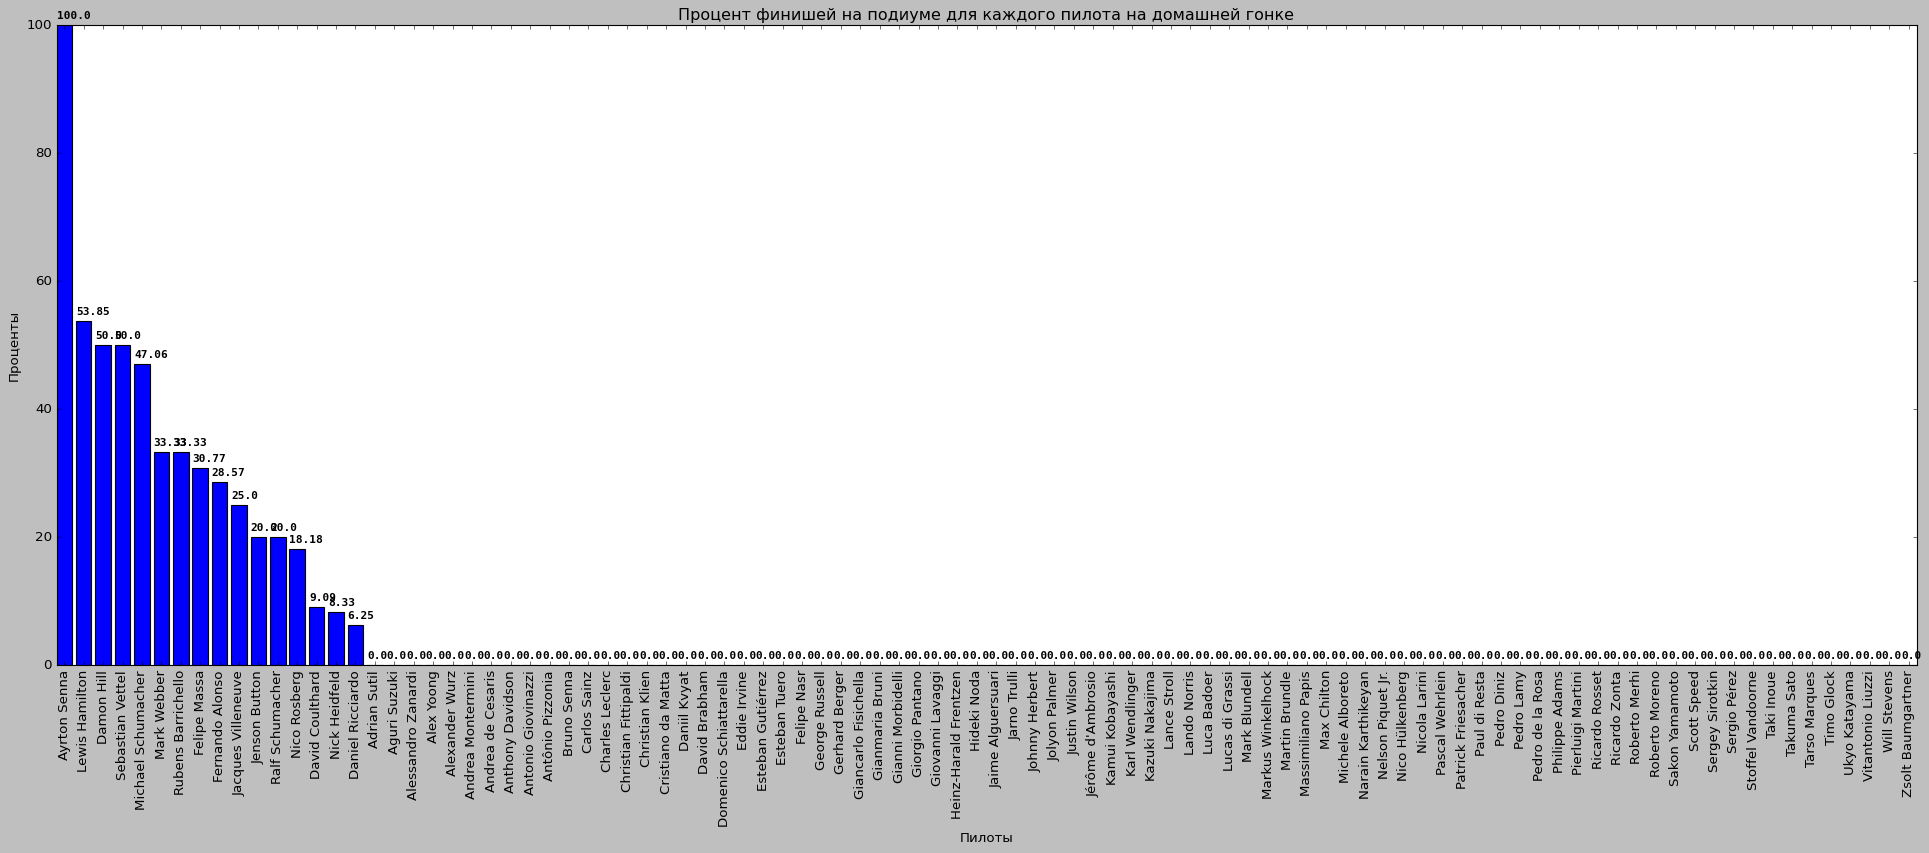

In [21]:
#график, отображающий процентное соотношение финишей пилота на родной трассе на подиуме
driver_home_podium_finish = data.loc[(data['position']<4)&(data['driver_home']==1)].groupby('driver').count()['position']
total_home_races = data[data['driver_home']==1].groupby('driver')['driver_home'].sum()
driver_home_podium_finish_ratio = (driver_home_podium_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=driver_home_podium_finish_ratio.index,height=driver_home_podium_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Пилоты')
plt.ylabel('Проценты')
plt.title('Процент финишей на подиуме для каждого пилота на домашней гонке')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x(),yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

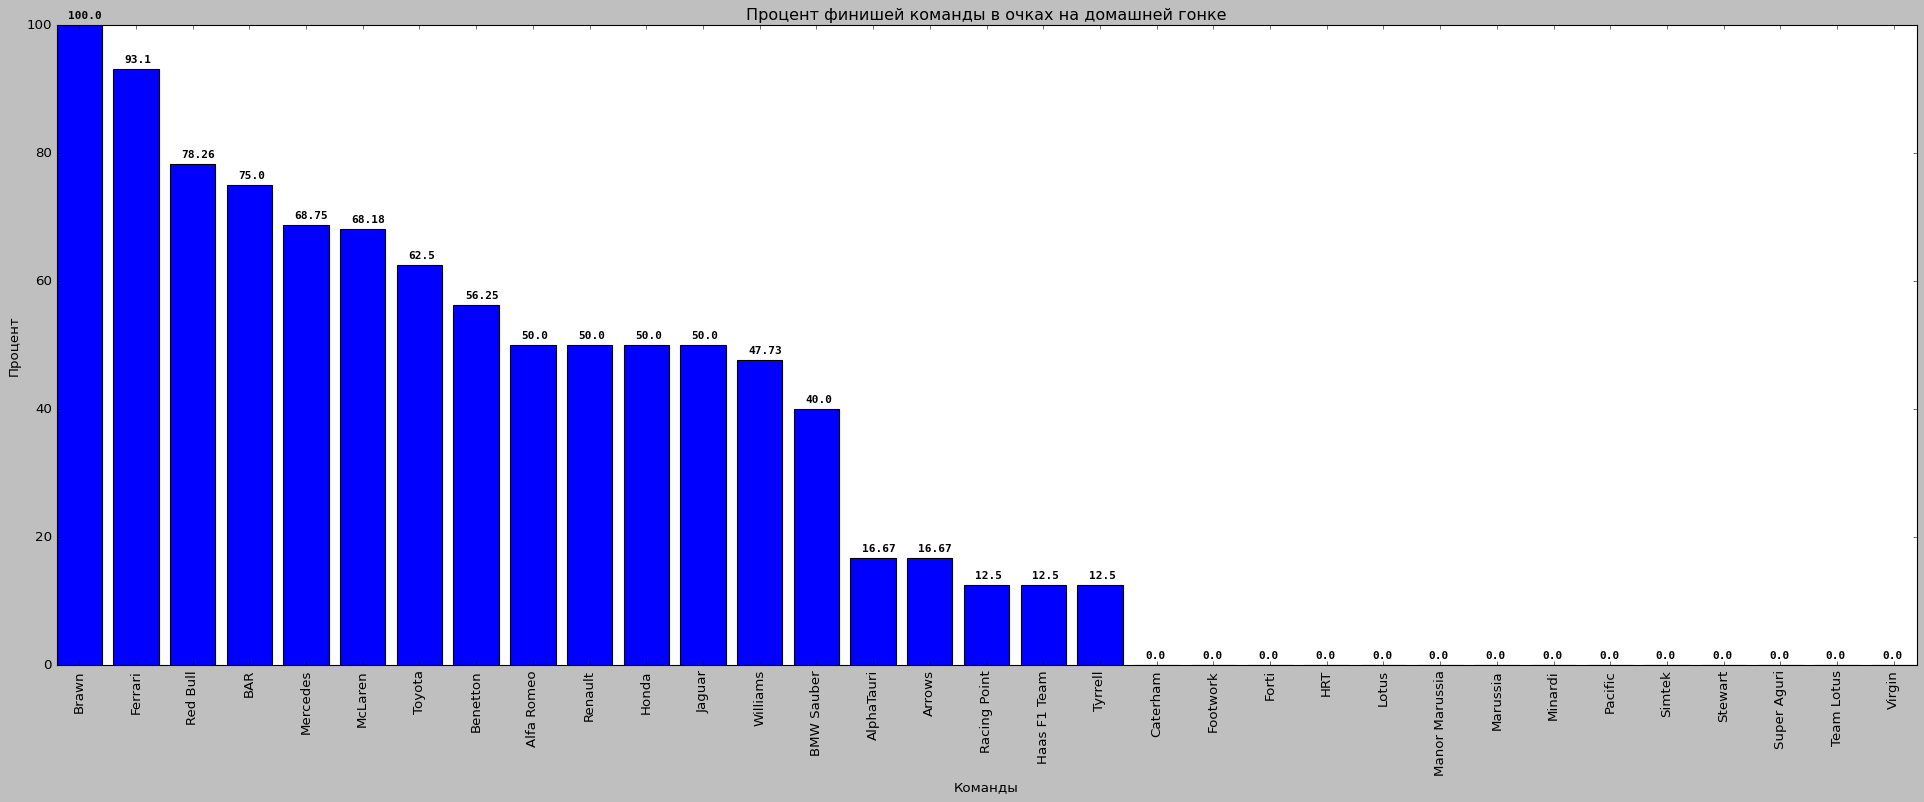

In [23]:
#график финишей команды на родной гонке в очках
constructor_home_points_finish = data.loc[(data['position']<11)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor')['constructor_home'].sum()
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Команды')
plt.ylabel('Процент')
plt.title('Процент финишей команды в очках на домашней гонке')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

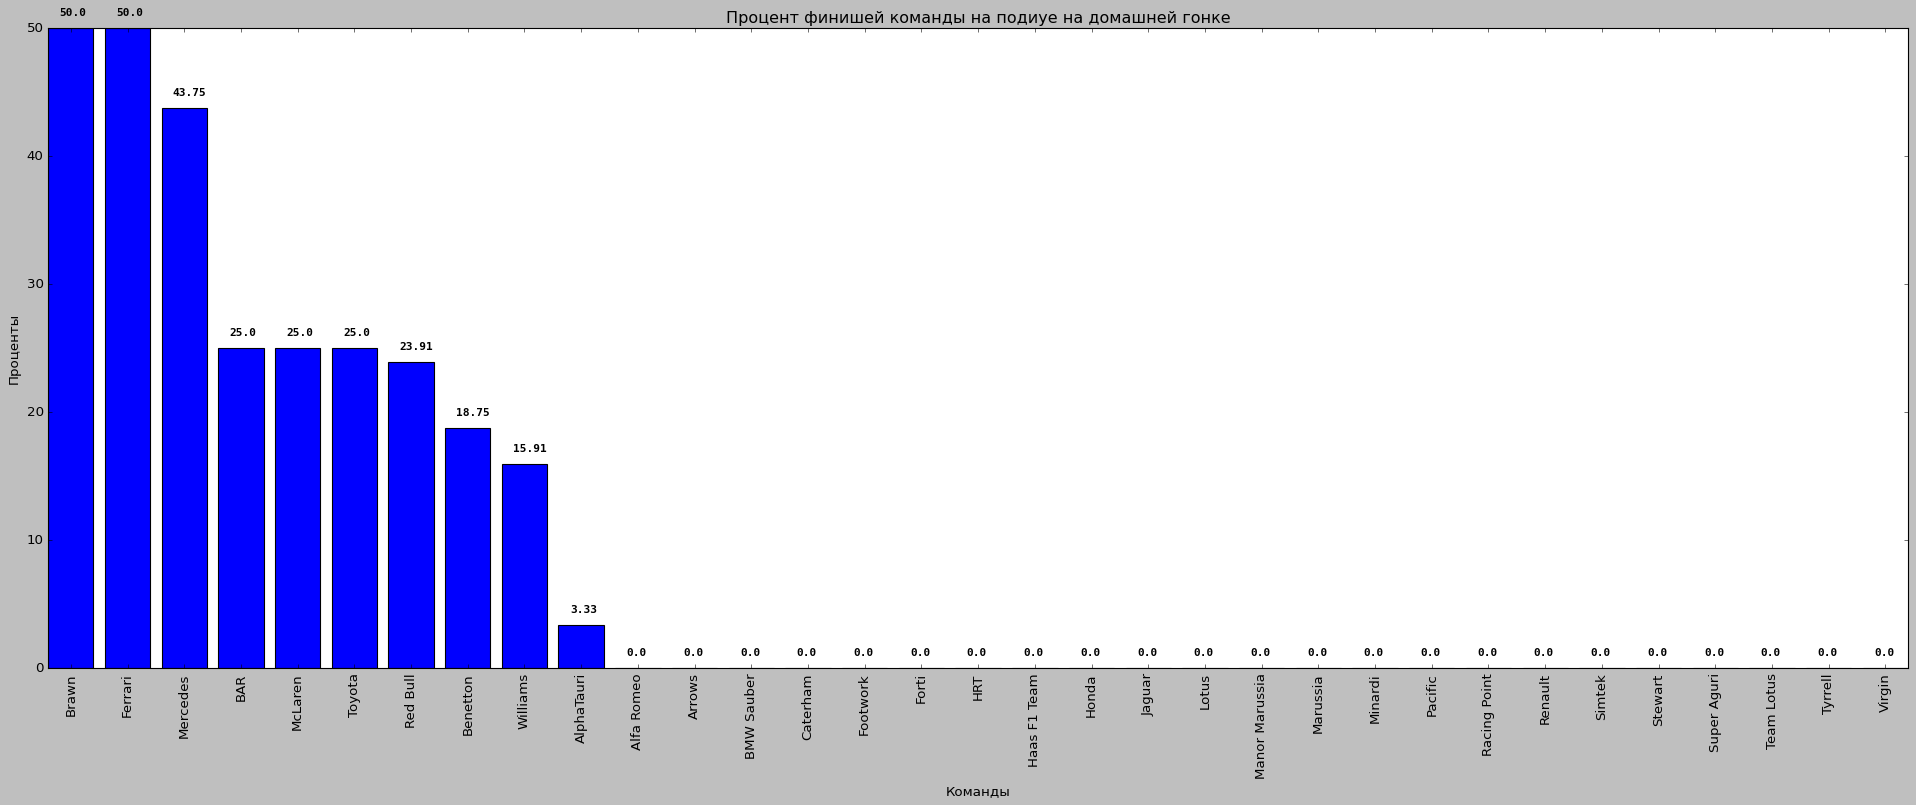

In [24]:
#график финишей команды на родной гонке на подиуме
constructor_home_points_finish = data.loc[(data['position']<4)&(data['constructor_home']==1)].groupby('constructor').count()['position']
total_home_races = data[data['constructor_home']==1].groupby('constructor')['constructor_home'].sum()
constructor_home_point_finish_ratio = (constructor_home_points_finish*100/total_home_races).sort_values(ascending=False).fillna(0)
plt.figure(figsize=(30,10))
bars = plt.bar(x=constructor_home_point_finish_ratio.index,height=constructor_home_point_finish_ratio,align='center',width=0.8)
plt.xticks(rotation=90)
plt.xlabel('Команды')
plt.ylabel('Проценты')
plt.title('Процент финишей команды на подиуе на домашней гонке')
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2,yval+1,f'{round(yval,2)}',fontdict=font)
plt.show()

In [26]:
#расчет коэффицента доверия пилота на основе общего кол-ва гонок и гонок в которых он не финишировал
dnf_by_driver = data.groupby('driver')['driver_dnf'].sum()
driver_race_entered = data.groupby('driver').count()['driver_dnf']
#соотношение DNF ко всем гонкам
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
#коэффицент доверия пилота
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [27]:
#аналогично пилоту рассчитывается коэффицент надежности команды(производителя)
dnf_by_constructor = data.groupby('constructor')['constructor_dnf'].sum()
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_relaiblity = 1-constructor_dnf_ratio
constructor_relaiblity_dict = dict(zip(constructor_relaiblity.index,constructor_relaiblity))

In [28]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_relaiblity'] = data['constructor'].apply(lambda x:constructor_relaiblity_dict[x])

In [37]:
active_constructors = ['Renault', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Racing Point', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat',
                  'Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Romain Grosjean','Nicholas Latifi']

In [38]:
#создание метки активной/не активно команды или пилота
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [39]:
data

,year,date,quali_pos,statusId,position,dob,driver_nationality,constructor,constructor_nationality,url,...,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf,driver_confidence,constructor_relaiblity,active_driver,active_constructor
0,2009,2009-03-29,1,1,1,1980-01-19,Bri,Brawn,Bri,http://en.wikipedia.org/wiki/Brawn_GP,...,Jenson Button,10662,0,0,0,0,0.923954,0.970588,0,0
1,2009,2009-03-29,2,1,2,1972-05-23,Bra,Brawn,Bri,http://en.wikipedia.org/wiki/Brawn_GP,...,Rubens Barrichello,13459,0,0,0,0,0.907080,0.970588,0,0
2,2009,2009-03-29,20,1,8,1974-07-13,Ita,Toyota,Jap,http://en.wikipedia.org/wiki/Toyota_Racing,...,Jarno Trulli,12678,0,0,0,0,0.903226,0.500000,0,0
3,2009,2009-03-29,19,1,6,1982-03-18,Ger,Toyota,Jap,http://en.wikipedia.org/wiki/Toyota_Racing,...,Timo Glock,9873,0,0,0,0,0.914894,0.500000,0,0
4,2009,2009-03-29,10,1,12,1981-07-29,Spa,Renault,Fre,http://en.wikipedia.org/wiki/Renault_in_Formul...,...,Fernando Alonso,10105,0,0,0,0,0.932660,0.601852,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8398,2020,2020-07-19,18,11,18,1986-04-17,Fre,Haas F1 Team,Ame,http://en.wikipedia.org/wiki/Haas_F1_Team,...,Romain Grosjean,12512,0,0,0,1,0.852071,0.343023,1,1
8399,2020,2020-07-19,19,11,19,1993-12-14,Ita,Alfa Romeo,Ita,http://en.wikipedia.org/wiki/Alfa_Romeo_in_For...,...,Antonio Giovinazzi,9714,0,0,0,1,0.880000,0.395276,1,1
8400,2020,2020-07-19,12,11,12,1998-02-15,Bri,Williams,Bri,http://en.wikipedia.org/wiki/Williams_Grand_Pr...,...,George Russell,8190,0,0,0,1,0.958333,0.569961,1,1
8401,2020,2020-07-19,15,15,15,1995-06-29,Can,Williams,Bri,http://en.wikipedia.org/wiki/Williams_Grand_Pr...,...,Nicholas Latifi,9152,0,0,0,1,1.000000,0.569961,1,1


In [33]:
#сохраняем чистые данные
cleaned_data = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_relaiblity','active_driver','active_constructor','dob']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
if not os.path.exists('cleaned_data.csv'):
    cleaned_data.to_csv('cleaned_data.csv',index=False)

In [34]:
cleaned_data.head()

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob
12,Albert Park Grand Prix Circuit,3,Red Bull,Sebastian Vettel,3,0.934156,0.750865,1,1,1987-07-03
14,Albert Park Grand Prix Circuit,7,Ferrari,Kimi Räikkönen,9,0.933798,0.824359,1,1,1979-10-17
19,Albert Park Grand Prix Circuit,18,McLaren,Lewis Hamilton,15,0.940711,0.634492,1,1,1985-01-07
26,Sepang International Circuit,12,McLaren,Lewis Hamilton,13,0.940711,0.634492,1,1,1985-01-07
33,Sepang International Circuit,7,Ferrari,Kimi Räikkönen,9,0.933798,0.824359,1,1,1979-10-17


In [35]:
x = cleaned_data

In [36]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [41]:
constructor_names = ['Ferrari', 'Red Bull', 'Mercedes', 'Racing Point', 'Williams', 'Alfa Romeo', 'AlphaTauri', 'McLaren', 'Renault', 'Haas F1 Team']
drivers = [
    'Lewis Hamilton',
    'George Russell',
    'Max Verstappen',
    'Sergio Pérez',
    'Charles Leclerc',
    'Carlos Sainz',
    'Lando Norris',
    'Oscar Piastri',
    'Esteban Ocon',
    'Pierre Gasly',
    'Yuki Tsunoda',
    'Nyck de Vries',
    'Fernando Alonso',
    'Lance Stroll',
    'Valtteri Bottas',
    'Zhou Guanyu',
    'Alex Albon',
    'Logan Sargeant',
    'Kevin Magnussen',
    'Nico Hulkenberg'
]

In [59]:
constructor_reliabilities_dict = {}

for constructor in constructor_names:
    constructor_data = cleaned_data[cleaned_data['constructor'] == constructor]
    constructor_reliabilities_dict[constructor] = constructor_data.iloc[0]['constructor_relaiblity']

print("Надежность конструкторов(команд):")
for name in constructor_names:
    reliability = cleaned_data.loc[cleaned_data['constructor'] == name, 'constructor_relaiblity'].values[0]
    print(f"{name}: {reliability}")

Надежность конструкторов(команд):
Ferrari: 0.8243589743589743
Red Bull: 0.7508650519031141
Mercedes: 0.8778054862842892
Racing Point: 0.5902335456475584
Williams: 0.5699614890885751
Alfa Romeo: 0.3952755905511811
AlphaTauri: 0.4553903345724907
McLaren: 0.6344916344916345
Renault: 0.6018518518518519
Haas F1 Team: 0.34302325581395354


In [43]:
driver_confidence_dict = {}

for driver in drivers:
    driver_data = cleaned_data[cleaned_data['driver'] == driver]
    if len(driver_data) > 0:
        driver_confidence_dict[driver] = driver_data.iloc[0]['driver_confidence']
    else:
        driver_confidence_dict[driver] = 0.8

print("Коэффицент доверия пилотов:")
for driver, confidence in driver_confidence_dict.items():
    print(f"{driver}: {confidence}")

Коэффицент доверия пилотов:
Lewis Hamilton: 0.9407114624505929
George Russell: 0.9583333333333334
Max Verstappen: 0.9142857142857143
Sergio Pérez: 0.9333333333333333
Charles Leclerc: 0.8444444444444444
Carlos Sainz: 0.9038461538461539
Lando Norris: 0.9166666666666666
Oscar Piastri: 0.8
Esteban Ocon: 0.9230769230769231
Pierre Gasly: 0.9387755102040817
Yuki Tsunoda: 0.8
Nyck de Vries: 0.8
Fernando Alonso: 0.8
Lance Stroll: 0.9230769230769231
Valtteri Bottas: 0.965034965034965
Zhou Guanyu: 0.8
Alex Albon: 0.8
Logan Sargeant: 0.8
Kevin Magnussen: 0.9523809523809523
Nico Hulkenberg: 0.8


In [44]:
driver_confidence_dict

{'Lewis Hamilton': 0.9407114624505929,
 'George Russell': 0.9583333333333334,
 'Max Verstappen': 0.9142857142857143,
 'Sergio Pérez': 0.9333333333333333,
 'Charles Leclerc': 0.8444444444444444,
 'Carlos Sainz': 0.9038461538461539,
 'Lando Norris': 0.9166666666666666,
 'Oscar Piastri': 0.8,
 'Esteban Ocon': 0.9230769230769231,
 'Pierre Gasly': 0.9387755102040817,
 'Yuki Tsunoda': 0.8,
 'Nyck de Vries': 0.8,
 'Fernando Alonso': 0.8,
 'Lance Stroll': 0.9230769230769231,
 'Valtteri Bottas': 0.965034965034965,
 'Zhou Guanyu': 0.8,
 'Alex Albon': 0.8,
 'Logan Sargeant': 0.8,
 'Kevin Magnussen': 0.9523809523809523,
 'Nico Hulkenberg': 0.8}

In [60]:
constructor_reliabilities_dict

{'Ferrari': 0.8243589743589743,
 'Red Bull': 0.7508650519031141,
 'Mercedes': 0.8778054862842892,
 'Racing Point': 0.5902335456475584,
 'Williams': 0.5699614890885751,
 'Alfa Romeo': 0.3952755905511811,
 'AlphaTauri': 0.4553903345724907,
 'McLaren': 0.6344916344916345,
 'Renault': 0.6018518518518519,
 'Haas F1 Team': 0.34302325581395354}

In [45]:
cleaned_data['istest'] = 0

In [46]:
cleaned_data

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest
12,Albert Park Grand Prix Circuit,3,Red Bull,Sebastian Vettel,3,0.934156,0.750865,1,1,1987-07-03,0
14,Albert Park Grand Prix Circuit,7,Ferrari,Kimi Räikkönen,9,0.933798,0.824359,1,1,1979-10-17,0
19,Albert Park Grand Prix Circuit,18,McLaren,Lewis Hamilton,15,0.940711,0.634492,1,1,1985-01-07,0
26,Sepang International Circuit,12,McLaren,Lewis Hamilton,13,0.940711,0.634492,1,1,1985-01-07,0
33,Sepang International Circuit,7,Ferrari,Kimi Räikkönen,9,0.933798,0.824359,1,1,1979-10-17,0
...,...,...,...,...,...,...,...,...,...,...,...
8398,Hungaroring,18,Haas F1 Team,Romain Grosjean,18,0.852071,0.343023,1,1,1986-04-17,0
8399,Hungaroring,19,Alfa Romeo,Antonio Giovinazzi,19,0.880000,0.395276,1,1,1993-12-14,0
8400,Hungaroring,12,Williams,George Russell,12,0.958333,0.569961,1,1,1998-02-15,0
8401,Hungaroring,15,Williams,Nicholas Latifi,15,1.000000,0.569961,1,1,1995-06-29,0


In [68]:
#подготовка данных для тестового датасета
driver_confidences = [0.8444444444444444, 0.9142857142857143, 0.9333333333333333, 0.9038461538461539, 
                      0.9407114624505929, 0.8, 0.9166666666666666, 0.8, 0.9230769230769231, 0.8, 
                      0.9583333333333334, 0.9230769230769231, 0.8, 0.965034965034965, 0.8, 0.8, 
                      0.8, 0.9523809523809523, 0.9387755102040817, 0.8]


drivers = ["Charles Leclerc", "Max Verstappen", "Sergio Pérez", "Carlos Sainz Jr.", "Lewis Hamilton", "Fernando Alonso","Lando Norris", "Yuki Tsunoda", "Lance Stroll", "Oscar Piastri", "George Russell", "Esteban Ocon","Alexander Albon", "Valtteri Bottas", "Logan Sargeant", "Zhou Guanyu", "Nico Hülkenberg", "Kevin Magnussen","Pierre Gasly", "Nyck de Vries"]

constructor_reliabilities = [0.8243589743589743, 0.7508650519031141, 0.7508650519031141, 0.8243589743589743,
0.8778054862842892, 0.5902335456475584, 0.6344916344916345, 0.4553903345724907,
0.5902335456475584, 0.6344916344916345, 0.8778054862842892, 0.6018518518518519,
0.5699614890885751, 0.3952755905511811, 0.5699614890885751, 0.3952755905511811,
0.34302325581395354, 0.34302325581395354, 0.6018518518518519, 0.4553903345724907]

In [69]:
#Создание словаря тестовых данных
newdata = {
    'GP_name': ['Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit','Baku City Circuit'],
    'quali_pos': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'constructor': ["Ferrari", "Red Bull","Red Bull","Ferrari","Mercedes","Racing Point","McLaren","AlphaTauri","Racing Point","McLaren", "Mercedes","Renault","Williams", "Alfa Romeo","Williams","Alfa Romeo","Haas F1 Team","Haas F1 Team","Renault","AlphaTauri"],
    'driver': drivers,
    'driver_confidence': driver_confidences,
    'constructor_relaiblity':constructor_reliabilities,
    'active_driver': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    'active_constructor': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    'dob': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
}

In [70]:
# Создание тестового датафрейма
new_data = pd.DataFrame(newdata)
new_data['istest'] = 1

new_data

,GP_name,quali_pos,constructor,driver,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest
0,Baku City Circuit,1,Ferrari,Charles Leclerc,0.844444,0.824359,1,1,1,1
1,Baku City Circuit,2,Red Bull,Max Verstappen,0.914286,0.750865,1,1,1,1
2,Baku City Circuit,3,Red Bull,Sergio Pérez,0.933333,0.750865,1,1,1,1
3,Baku City Circuit,4,Ferrari,Carlos Sainz Jr.,0.903846,0.824359,1,1,1,1
4,Baku City Circuit,5,Mercedes,Lewis Hamilton,0.940711,0.877805,1,1,1,1
5,Baku City Circuit,6,Racing Point,Fernando Alonso,0.800000,0.590234,1,1,1,1
6,Baku City Circuit,7,McLaren,Lando Norris,0.916667,0.634492,1,1,1,1
7,Baku City Circuit,8,AlphaTauri,Yuki Tsunoda,0.800000,0.455390,1,1,1,1
8,Baku City Circuit,9,Racing Point,Lance Stroll,0.923077,0.590234,1,1,1,1
9,Baku City Circuit,10,McLaren,Oscar Piastri,0.800000,0.634492,1,1,1,1


In [71]:
cleaned_data = pd.concat([cleaned_data,new_data])

In [72]:
cleaned_data

,GP_name,quali_pos,constructor,driver,position,driver_confidence,constructor_relaiblity,active_driver,active_constructor,dob,istest
12,Albert Park Grand Prix Circuit,3,Red Bull,Sebastian Vettel,3.0,0.934156,0.750865,1,1,1987-07-03 00:00:00,0
14,Albert Park Grand Prix Circuit,7,Ferrari,Kimi Räikkönen,9.0,0.933798,0.824359,1,1,1979-10-17 00:00:00,0
19,Albert Park Grand Prix Circuit,18,McLaren,Lewis Hamilton,15.0,0.940711,0.634492,1,1,1985-01-07 00:00:00,0
26,Sepang International Circuit,12,McLaren,Lewis Hamilton,13.0,0.940711,0.634492,1,1,1985-01-07 00:00:00,0
33,Sepang International Circuit,7,Ferrari,Kimi Räikkönen,9.0,0.933798,0.824359,1,1,1979-10-17 00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...
15,Baku City Circuit,16,Alfa Romeo,Zhou Guanyu,NaN,0.800000,0.395276,1,1,1,1
16,Baku City Circuit,17,Haas F1 Team,Nico Hülkenberg,NaN,0.800000,0.343023,1,1,1,1
17,Baku City Circuit,18,Haas F1 Team,Kevin Magnussen,NaN,0.952381,0.343023,1,1,1,1
18,Baku City Circuit,19,Renault,Pierre Gasly,NaN,0.938776,0.601852,1,1,1,1


In [73]:
sc  = StandardScaler()
le = LabelEncoder()

#стандартизируем данные
x = cleaned_data
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position','active_driver','active_constructor'],axis=1)
X_test_new = X[X['istest'] == 1]
X = X[X['istest']== 0]
y = x[x['istest'] == 0]['position'].apply(lambda x: position_index(x))

In [74]:
X = X.drop('dob', axis=1)
X_test_new =  X_test_new.drop('dob', axis=1)

In [75]:
X.columns

Index(['GP_name', 'quali_pos', 'constructor', 'driver', 'driver_confidence',
       'constructor_relaiblity', 'istest'],
      dtype='object')

In [76]:
y

12      1
14      2
19      3
26      3
33      2
       ..
8398    3
8399    3
8400    3
8401    3
8402    2
Name: position, Length: 2149, dtype: int64

# Сравнение показателей различных моделей

In [81]:
#кроссвалидация для различных моделей
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=1, shuffle = True)
    result = cross_val_score(model,X,y,cv=cv,scoring='f1_weighted')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

c:\Users\Влад\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Влад\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

LogisticRegression : 0.9208841840798117
DecisionTreeClassifier : 0.9096332706974465
RandomForestClassifier : 0.9329183096171187
SVC : 0.9287986724453701
KNeighborsClassifier : 0.894386231926417


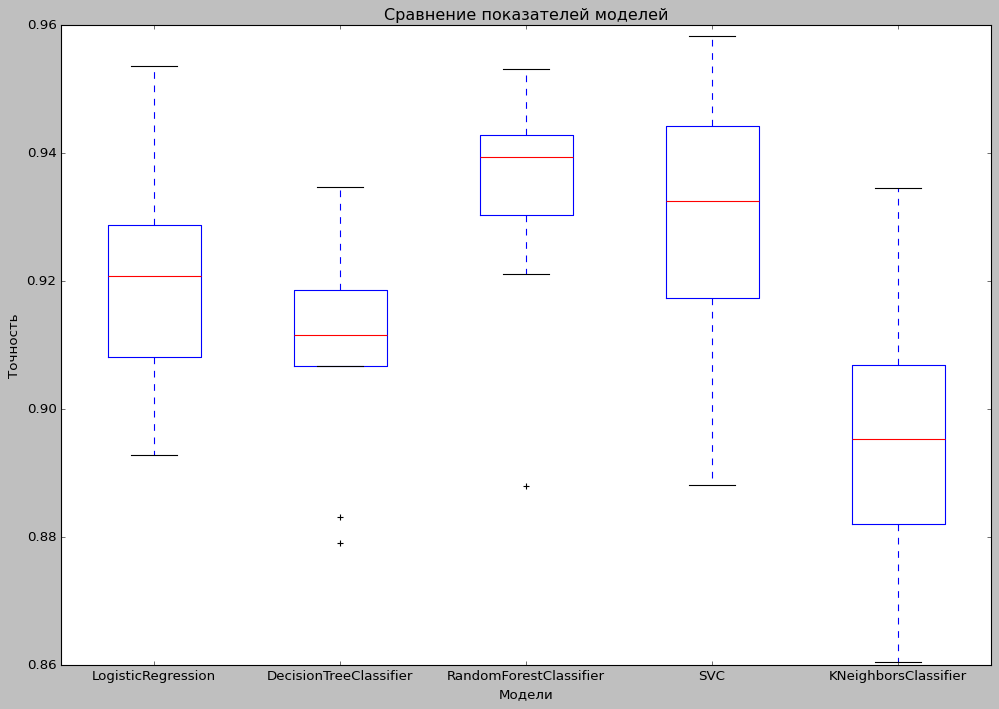

In [83]:
plt.figure(figsize=(15,10))
plt.boxplot(x=results,labels=name)
plt.xlabel('Модели')
plt.ylabel('Точность')
plt.title('Сравнение показателей моделей')
plt.show()

# Обучение модели

In [84]:
n_estimators = [int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
min_samples_split = [2,5,8,10,15,20]
min_samples_leaf = [1,2,4,6,8,10]
bootstrap = [True,False]

random_parms = {
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf,
    'bootstrap':bootstrap
                }

In [88]:
X.shape

(2149, 7)

In [85]:
y = np.array(y).reshape(-1, 1)
y = pd.Series(y.flatten())

In [87]:
y.shape

(2149,)

In [91]:
rf_rand = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf_rand,param_distributions=random_parms,n_iter=10,cv=10,verbose=2,n_jobs=-1)
rf_random.fit(X,y)
rf_random.best_params_

Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\Влад\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Влад\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Влад\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Влад\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", 

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [115]:
rf = RandomForestClassifier(n_estimators=1200,min_samples_split=5,min_samples_leaf=4,max_features='sqrt',max_depth=110,bootstrap=True)
# kf = StratifiedKFold(n_splits=10,random_state=None,shuffle=False)
# for train_index,test_index in kf.split(X,y):
#     X_train,X_test = X.iloc[train_index],X.iloc[test_index]
#     y_train,y_test = y.iloc[train_index],y.iloc[test_index]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
X_test

,GP_name,quali_pos,constructor,driver,driver_confidence,constructor_relaiblity,istest
7108,1,2,2,23,0.934156,0.824359,0
8046,9,3,2,4,0.844444,0.824359,0
6744,11,8,1,2,0.903846,0.455390,0
6326,6,1,5,14,0.940711,0.877805,0
6546,29,8,8,22,0.852071,0.601852,0
...,...,...,...,...,...,...,...
6998,25,5,2,23,0.934156,0.824359,0
8234,28,14,6,12,0.923077,0.590234,0
5482,1,14,1,5,0.942197,0.455390,0
5800,8,6,8,11,0.933798,0.601852,0


In [117]:
y_test

1159    1
1822    1
978     2
759     1
874     2
       ..
1103    2
1991    3
445     3
548     2
25      2
Length: 430, dtype: int64

In [118]:
X_train

,GP_name,quali_pos,constructor,driver,driver_confidence,constructor_relaiblity,istest
7523,1,20,1,21,0.938776,0.455390,0
6028,9,14,8,22,0.852071,0.601852,0
486,9,1,4,14,0.940711,0.634492,0
5174,30,4,8,22,0.852071,0.601852,0
8240,28,17,9,9,0.958333,0.569961,0
...,...,...,...,...,...,...,...
7814,28,6,6,7,0.923077,0.590234,0
6980,25,6,2,11,0.933798,0.824359,0
7048,4,6,2,11,0.933798,0.824359,0
7310,18,4,5,14,0.940711,0.877805,0


In [119]:
y_train

1433    3
630     3
78      1
366     2
1996    3
       ..
1638    2
1095    2
1130    2
1294    2
860     1
Length: 1719, dtype: int64

In [94]:
data

,year,date,quali_pos,statusId,position,dob,driver_nationality,constructor,constructor_nationality,url,...,driver,age_at_gp_in_days,driver_home,constructor_home,driver_dnf,constructor_dnf,driver_confidence,constructor_relaiblity,active_driver,active_constructor
0,2009,2009-03-29,1,1,1,1980-01-19,Bri,Brawn,Bri,http://en.wikipedia.org/wiki/Brawn_GP,...,Jenson Button,10662,0,0,0,0,0.923954,0.970588,0,0
1,2009,2009-03-29,2,1,2,1972-05-23,Bra,Brawn,Bri,http://en.wikipedia.org/wiki/Brawn_GP,...,Rubens Barrichello,13459,0,0,0,0,0.907080,0.970588,0,0
2,2009,2009-03-29,20,1,8,1974-07-13,Ita,Toyota,Jap,http://en.wikipedia.org/wiki/Toyota_Racing,...,Jarno Trulli,12678,0,0,0,0,0.903226,0.500000,0,0
3,2009,2009-03-29,19,1,6,1982-03-18,Ger,Toyota,Jap,http://en.wikipedia.org/wiki/Toyota_Racing,...,Timo Glock,9873,0,0,0,0,0.914894,0.500000,0,0
4,2009,2009-03-29,10,1,12,1981-07-29,Spa,Renault,Fre,http://en.wikipedia.org/wiki/Renault_in_Formul...,...,Fernando Alonso,10105,0,0,0,0,0.932660,0.601852,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8398,2020,2020-07-19,18,11,18,1986-04-17,Fre,Haas F1 Team,Ame,http://en.wikipedia.org/wiki/Haas_F1_Team,...,Romain Grosjean,12512,0,0,0,1,0.852071,0.343023,1,1
8399,2020,2020-07-19,19,11,19,1993-12-14,Ita,Alfa Romeo,Ita,http://en.wikipedia.org/wiki/Alfa_Romeo_in_For...,...,Antonio Giovinazzi,9714,0,0,0,1,0.880000,0.395276,1,1
8400,2020,2020-07-19,12,11,12,1998-02-15,Bri,Williams,Bri,http://en.wikipedia.org/wiki/Williams_Grand_Pr...,...,George Russell,8190,0,0,0,1,0.958333,0.569961,1,1
8401,2020,2020-07-19,15,15,15,1995-06-29,Can,Williams,Bri,http://en.wikipedia.org/wiki/Williams_Grand_Pr...,...,Nicholas Latifi,9152,0,0,0,1,1.000000,0.569961,1,1


In [95]:
data.columns

Index(['year', 'date', 'quali_pos', 'statusId', 'position', 'dob',
       'driver_nationality', 'constructor', 'constructor_nationality', 'url',
       'GP_name', 'country', 'driver', 'age_at_gp_in_days', 'driver_home',
       'constructor_home', 'driver_dnf', 'constructor_dnf',
       'driver_confidence', 'constructor_relaiblity', 'active_driver',
       'active_constructor'],
      dtype='object')

In [120]:
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=110, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=1200)

In [121]:
prediction = rf.predict(X_test)

In [122]:
from sklearn.metrics import f1_score
f1_score(y_test, prediction, average='weighted')

0.9442504071396001